In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mne
mne.__version__
from mne.viz import plot_alignment, snapshot_brain_montage
import shutil
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split

# from mne_bids import write_raw_bids, BIDSPath, print_dir_tree, make_dataset_description
# from mne_bids.stats import count_events
import sys


In [2]:
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

In [3]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 1 # Change the range so the process is faster
if amount_of_subjects > 26: amount_of_subjects = 26
subjs_list = ['s{:02d}'.format(i) for i in range(1, amount_of_subjects+1) if i != 6 ] 
print(subjs_list)
nSubj = len(subjs_list)

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = False # speeds up the procees but showing worse results overall
if resample: resample_frequency = 20 # in Hz, original freq is 500Hz

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'
# cfg_stim['Tuning'] = 'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.1
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

['s01']


In [4]:
from methods import read_data
all_rawdata = read_data (task = 'main', resample=False,subjs_list=subjs_list, resample_frequency=10)

In [5]:
all_rawdata[0]['metadata'].columns

Index(['index', 'subj', 'nblock', 'ntrial', 'nrep', 'trial_type', 'cond-1',
       'cond', 'rDV', 'DV', 'resp', 'deci-2', 'deci-1', 'deci', 'corr-1',
       'r_map', 'correct', 'confi', 'RT', 'd1', 'conf_lvl', 'correct-1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'confi-1',
       'conf_lvl-1'],
      dtype='object')

In [6]:
use_timepoint = False
reshape = False
timepoint = 10
X = all_rawdata[0]['epoch_dat']
print(X.shape)
# X = X.reshape(X.shape[0],-1)
y = all_rawdata[0]['metadata']['deci']
y = np.array(y)
print(y.shape)

for i in range(1, nSubj):

    X_temp = all_rawdata[i]['epoch_dat']
    # X_temp = X_temp.reshape((X_temp.shape[0]*X_temp.shape[1], X_temp.shape[2]))
    # shapes[i+1] = shapes[i] + X_temp.shape[0]
    y_temp = all_rawdata[i]['metadata']['deci']
    # y_temp = np.tile(y_temp, numC)
    X = np.vstack((X, X_temp))
    y = np.concatenate((y, y_temp))

print(X.shape, y.shape)
if use_timepoint: 
    X = X[:,:,timepoint]
else:
    if reshape:
        X = X.reshape(X.shape[0], -1)
print(X.shape, y.shape)

(250, 32, 2876)
(250,)
(250, 32, 2876) (250,)
(250, 32, 2876) (250,)


In [7]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC

def train_3(X, y, verbose=False, display_roc=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # clf = CatBoostClassifier(iterations=10, task_type = 'GPU') # Catboost takes too long even with GPU training
    clf = RandomForestClassifier()
    # clf = SVC()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)    
    if verbose:
        print(classification_report(y_test, y_pred))
        print(np.unique(y_test, return_counts=True))
        print(np.unique(y_pred, return_counts=True))
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    if display_roc:
        from sklearn.metrics import roc_curve
        from sklearn.metrics import RocCurveDisplay
        fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        return roc_display
    return accuracy, f1, roc

In [8]:
numT = X.shape[2]
timepoint_accuracy = [None]*numT
timepoint_f1 = [None]*numT
timepoint_roc = [None]*numT
for timepoint in range(numT):
    print(timepoint)
    X_training = X[:,:,timepoint]
    timepoint_accuracy[timepoint], timepoint_f1[timepoint], timepoint_roc[timepoint] = train_3(X_training, y)

0
Learning rate set to 0.5
0:	learn: 0.5560281	total: 2.93ms	remaining: 26.4ms
1:	learn: 0.4457699	total: 5.07ms	remaining: 20.3ms
2:	learn: 0.3741615	total: 7.01ms	remaining: 16.4ms
3:	learn: 0.3419313	total: 8.69ms	remaining: 13ms
4:	learn: 0.3069587	total: 10.3ms	remaining: 10.3ms
5:	learn: 0.2845690	total: 11.9ms	remaining: 7.94ms
6:	learn: 0.2453421	total: 13.5ms	remaining: 5.79ms
7:	learn: 0.2211061	total: 15.1ms	remaining: 3.77ms
8:	learn: 0.2020297	total: 17.1ms	remaining: 1.9ms
9:	learn: 0.1805647	total: 19.1ms	remaining: 0us
1
Learning rate set to 0.5
0:	learn: 0.5659885	total: 1.88ms	remaining: 16.9ms
1:	learn: 0.4691373	total: 3.9ms	remaining: 15.6ms
2:	learn: 0.4085660	total: 5.48ms	remaining: 12.8ms
3:	learn: 0.3776980	total: 6.99ms	remaining: 10.5ms
4:	learn: 0.3326828	total: 8.51ms	remaining: 8.51ms
5:	learn: 0.2970994	total: 10.1ms	remaining: 6.71ms
6:	learn: 0.2659903	total: 11.6ms	remaining: 4.97ms
7:	learn: 0.2342191	total: 13.1ms	remaining: 3.28ms
8:	learn: 0.21018

SystemError: <method '_train' of '_catboost._CatBoost' objects> returned a result with an exception set

f1 mean:  0.7472727808528326
acc mean:  0.6244645340751043


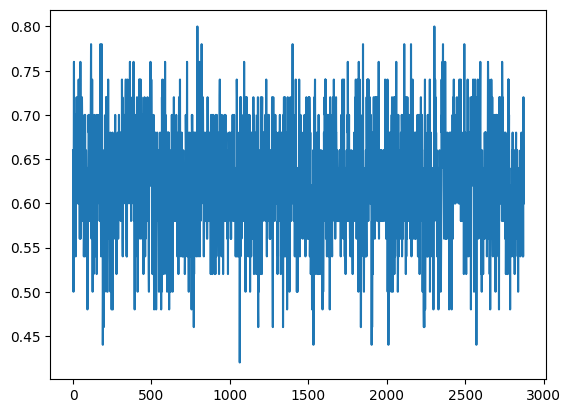

In [ ]:
print('f1 mean: ', np.mean(timepoint_f1))
print('acc mean: ', np.mean(timepoint_accuracy))
plt.plot(timepoint_accuracy)

In [ ]:
X_training = X[:,:,1500]
print(train_3(X_training, y, verbose=True))

              precision    recall  f1-score   support

           0       0.20      0.07      0.10        15
           1       0.69      0.89      0.78        35

    accuracy                           0.64        50
   macro avg       0.44      0.48      0.44        50
weighted avg       0.54      0.64      0.57        50

(array([0, 1]), array([15, 35]))
(array([0, 1]), array([ 5, 45]))
(0.64, 0.775, 0.47619047619047616)


In [ ]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)



ValueError: Found array with dim 3. RandomForestClassifier expected <= 2.

catboost and RF both on more data with stacked are perfoming the same

next im gonna add labels for the subjects


In [ ]:
display(all_rawdata[0]['metadata'].columns)

Index(['index', 'subj', 'nblock', 'ntrial', 'nrep', 'trial_type', 'cond-1',
       'cond', 'rDV', 'DV', 'resp', 'deci-2', 'deci-1', 'deci', 'corr-1',
       'r_map', 'correct', 'confi', 'RT', 'd1', 'conf_lvl', 'correct-1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'confi-1',
       'conf_lvl-1'],
      dtype='object')

In [ ]:
print(multivariate)

# multivariate test?

https://pypi.org/project/pyts/

In [ ]:
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

from pyts.datasets import load_basic_motions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

print(X_train.shape, y_train.shape)

# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf = MultivariateClassifier(BOSSVS())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)



(802, 32, 58) (802,)


ValueError: At least two consecutive quantiles are equal. Consider trying with a smaller number of bins or removing timestamps with low variation.